#### Notebook Interpretation

In this notebook, I explored and visualized different gradient descent optimization strategies for linear regression using PyTorch and Matplotlib. My goal was to understand how Batch Gradient Descent (BGD), Stochastic Gradient Descent (SGD), and Mini-Batch Gradient Descent (with various batch sizes) behave in terms of parameter updates and loss convergence.

#### Data Generation

I started by generating synthetic linear data with some added Gaussian noise. This allowed me to simulate a real-world regression problem where the underlying relationship is known, but the data is noisy.

#### Visualization Tools

To better understand the optimization process, I implemented a custom class, `plot_error_surfaces`, which visualizes both the loss surface and the trajectory of parameter updates (`w` and `b`) during training. This helped me see how the optimizer moves through the parameter space toward the minimum.

#### Model and Loss Function

I defined a simple linear model (`forward`) and used mean squared error as the loss function (`criterion`). These functions were used consistently across all optimization strategies.

#### Training with Different Gradient Descent Methods

- **Batch Gradient Descent (BGD):**  
  I trained the model using the entire dataset for each update. The loss decreased smoothly, and the parameter updates followed a direct path toward the minimum.

- **Stochastic Gradient Descent (SGD):**  
  Here, I updated the parameters after each individual data point. The loss curve was much noisier, and the parameter trajectory zigzagged more, but it still converged.

- **Mini-Batch Gradient Descent:**  
  I experimented with batch sizes of 5, 10, and 20. As the batch size increased, the loss curve became smoother, and the parameter updates became more stable, resembling BGD for larger batches.

#### Loss Comparison

Finally, I plotted the loss curves for all methods on the same graph. I customized the legend to make it clearer and more visually appealing, which helped me compare the convergence rates and stability of each method.

#### My Observations

- Smaller batch sizes (SGD and small mini-batches) lead to noisier but sometimes faster convergence.
- Larger batch sizes provide smoother loss curves but may require more computation per update.
- Visualizing the parameter updates on the loss surface gave me a deeper intuition about how each method explores the parameter space.

Overall, this notebook helped me build a strong intuition for how different gradient descent strategies work in practice and how batch size affects optimization dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help visualize the data space and the parameter space during training and has nothing to do with PyTorch. 

In [2]:
# The class for plotting the diagrams

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)  # Create a range of w values for the grid
        B = np.linspace(-b_range, b_range, n_samples)  # Create a range of b values for the grid
        w, b = np.meshgrid(W, B)    # Create a meshgrid for w and b
        Z = np.zeros((30, 30))      # Initialize a grid for loss values
        count1 = 0
        self.y = Y.numpy()          # Store Y as a numpy array for calculations
        self.x = X.numpy()          # Store X as a numpy array for calculations
        for w1, b1 in zip(w, b):    # Loop over each row in the meshgrid
            count2 = 0
            for w2, b2 in zip(w1, b1):  # Loop over each column in the meshgrid
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)  # Compute MSE loss for each (w, b)
                count2 += 1
            count1 += 1
        self.Z = Z                  # Store the loss surface
        self.w = w                  # Store the w grid
        self.b = b                  # Store the b grid
        self.W = []                 # List to store w values during training
        self.B = []                 # List to store b values during training
        self.LOSS = []              # List to store loss values during training
        self.n = 0                  # Counter for iterations
        if go == True:              # If go is True, plot the surfaces immediately
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
    # Setter to record parameter and loss history
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1         # Increment iteration counter
        self.W.append(W)            # Store current w
        self.B.append(B)            # Store current b
        self.LOSS.append(loss)      # Store current loss
    
    # Plot the 3D loss surface and parameter trajectory
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)  # Plot the loss surface wireframe
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)  # Plot parameter updates
        plt.figure()
        plt.contour(self.w, self.b, self.Z)        # Plot the contour of the loss surface
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')  # Plot parameter updates on contour
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot the data space and parameter space after each update
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim()
        plt.plot(self.x, self.y, 'ro', label = "training points")  # Plot training data
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")  # Plot current model
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Data Space Iteration: '+ str(self.n))
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)  # Plot loss surface contour
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')  # Plot parameter updates
        plt.title('Loss Surface Contour')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

# Generationg some Random Data

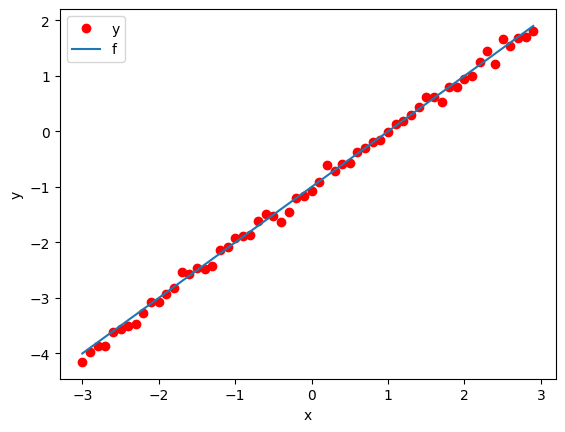

In [5]:
import torch  # Import PyTorch for tensor operations
torch.manual_seed(1)  # Set random seed for reproducibility

# Generate random linear data with noise
X = torch.arange(-3, 3, 0.1).view(-1, 1)  # Create input values from -3 to 3 in steps of 0.1, shape as column vector
f = 1 * X - 1  # Define the true linear relationship: slope=1, intercept=-1
Y = f + 0.1 * torch.randn(X.size())  # Add Gaussian noise (std=0.1) to the true line to simulate real data

# Plotting the data and line
plt.plot(X.numpy(), Y.numpy(), 'ro', label='y')  # Plot noisy data as red dots
plt.plot(X.numpy(), f.numpy(), label='f')        # Plot the true line
plt.xlabel('x')                                  # Label x-axis
plt.ylabel('y')                                  # Label y-axis
plt.legend()                                     # Show legend
plt.show()                                       # Display the plot

# Creating the Model and Cost Function (Total Loss)

<Figure size 640x480 with 0 Axes>

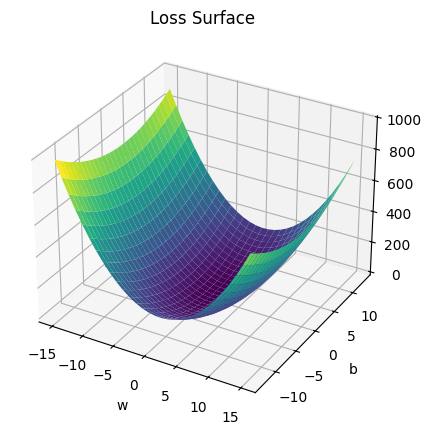

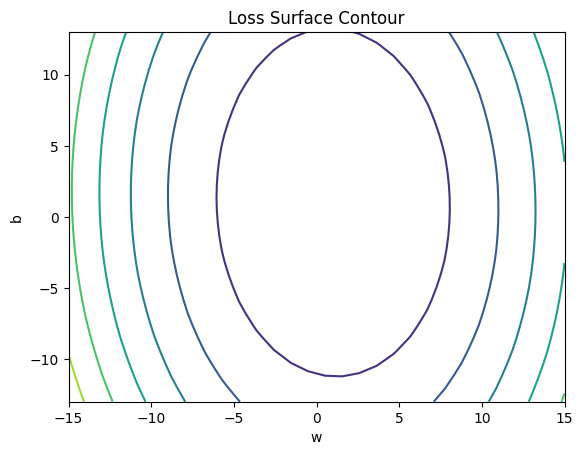

In [9]:
# Defining the prediction function
def forward(X):
    return w * X + b  # Linear model: y = wx + b

# Defining the loss function (Mean Squared Error)
def criterion(y, y_pred):
    return torch.mean((y - y_pred) ** 2)  # Compute mean squared error

# Creating the plot_error_surfaces object to visualize the loss surface
plot = plot_error_surfaces(15, 13, X, Y, 30)  # Initialize the plot_error_surfaces object with specified ranges for w and b


# Training the Model: Batch Gradient Descent

In [10]:
# Define the function to train the model using gradient descent
w = torch.tensor(-15.0, requires_grad=True)  # Initialize weight w with gradient tracking
b = torch.tensor(-10.0, requires_grad=True)  # Initialize bias b with gradient tracking
learning_rate = 0.1  # Set the learning rate for gradient descent
LOSS_BGD = []  # List to store loss values for each iteration

def train_model_BGD(epochs):
    for epoch in range(epochs):  # Loop over the number of epochs
        y_pred = model(X, w, b)  # Get model predictions using the defined model function
        loss = loss_fn(y_pred, Y)  # Compute the loss using the defined loss function
        LOSS_BGD.append(loss)
        plot.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())  # Record parameters and loss
        plot.plot_ps()  # Plot the data and parameter space
        loss.backward()
        w.data = w.data - learning_rate * w.grad.data
        b.data = b.data - learning_rate * b.grad.data
        w.grad.data.zero_()
        b.grad.data.zero_()

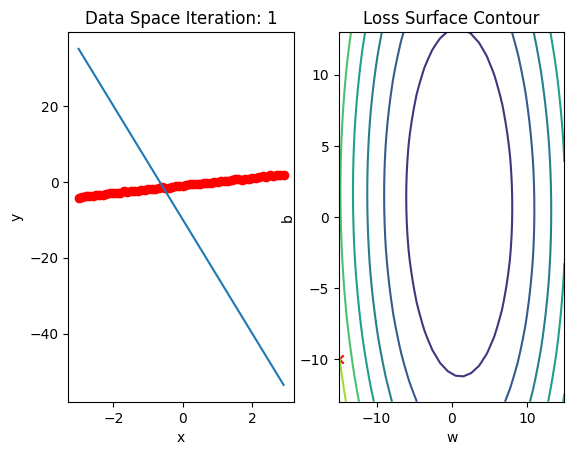

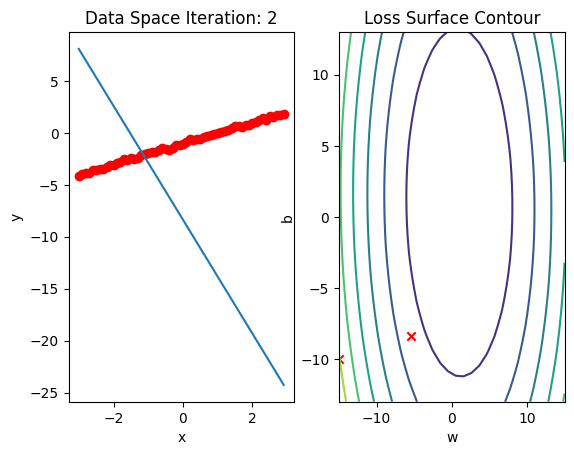

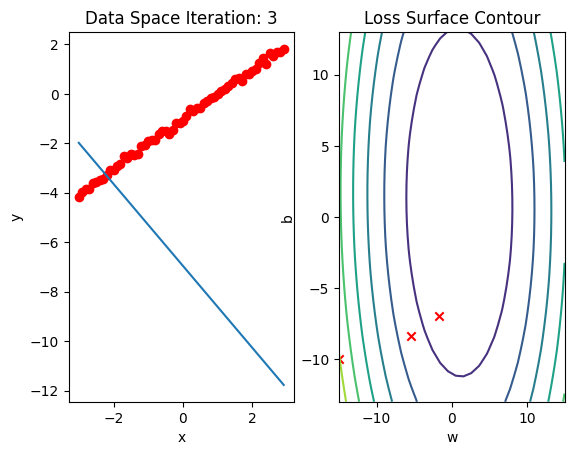

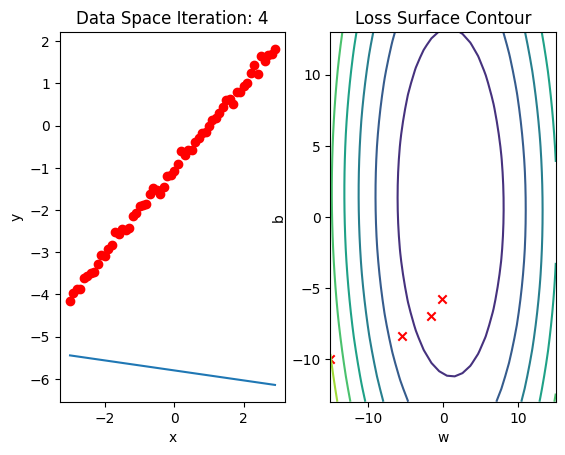

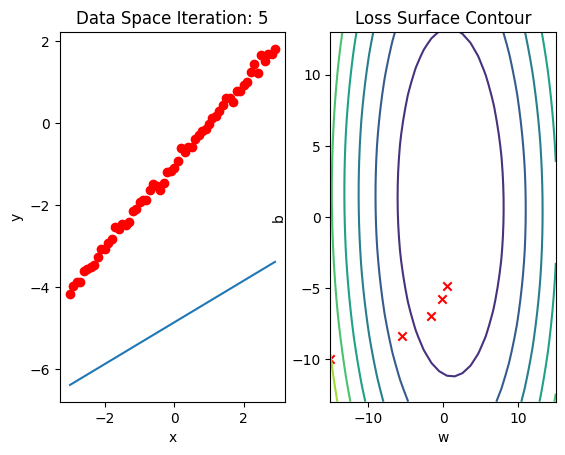

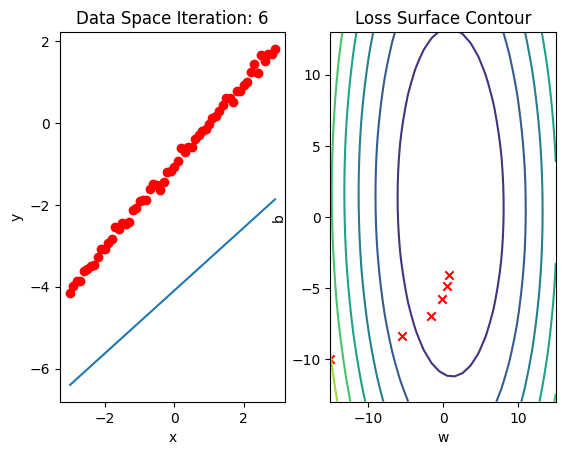

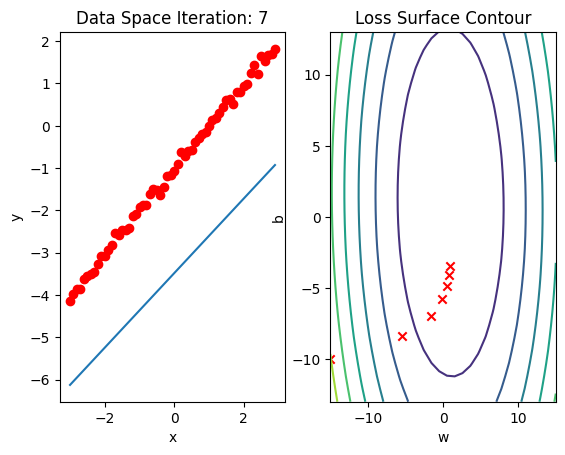

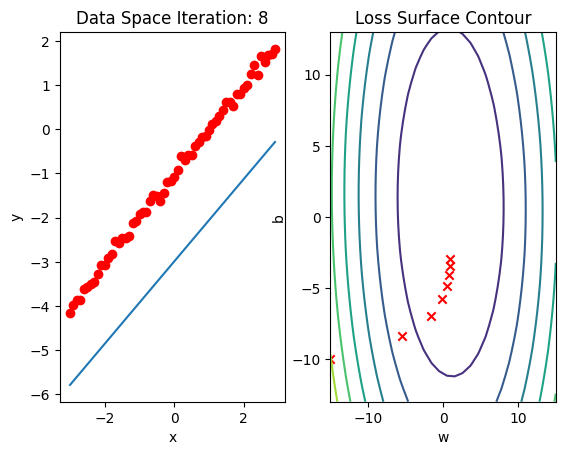

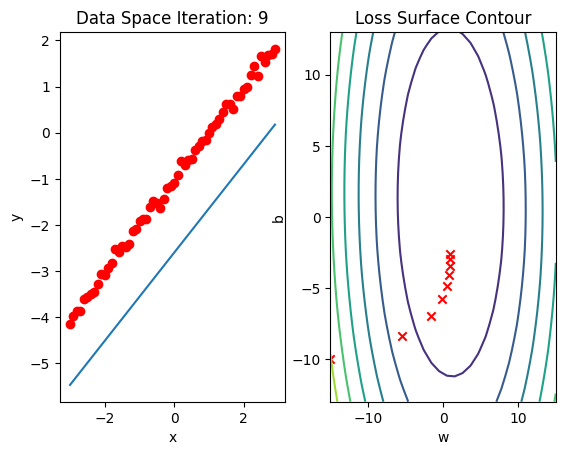

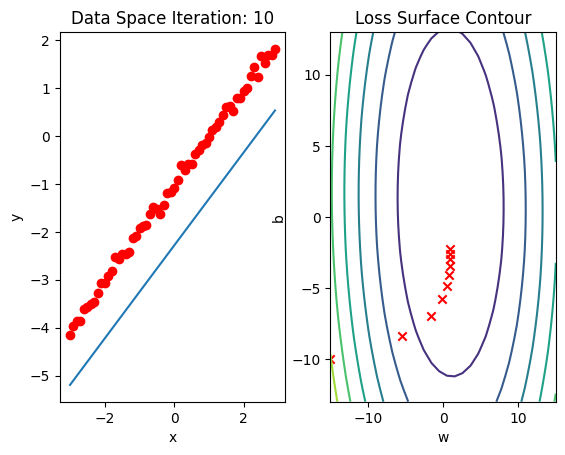

In [11]:
train_model_BGD(10)  # Train the model for 10 epochs

# Training the Model: Stohastic Gradient Descent with DatasetLoader

In [15]:
# Create a plot_error_surfaces object for visualizing parameter updates (but don't plot immediately)
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)

from torch.utils.data import Dataset, DataLoader  # Import PyTorch Dataset and DataLoader

# Create a custom dataset class for our linear data
class Data(Dataset):
    # constructor
    def __init__(self, x, y):
        self.x = x  # Store input features
        self.y = y  # Store target values
        self.len = self.x.shape[0]  # Store number of samples
    
    # Getter: returns a single (x, y) pair at the given index
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Return the total number of samples
    def __len__(self):
        return self.len

In [16]:
#  creating the dataset object and data loader
dataset = Data(X, Y)  # Create an instance of the custom dataset with X and Y data
trainloader = DataLoader(dataset = dataset, batch_size = 1)  # Create a DataLoader for batching and shuffling

# Define the model parameters
w = torch.tensor(-15.0, requires_grad=True)  # Initialize weight w with gradient tracking
b = torch.tensor(-10.0, requires_grad=True)  # Initialize bias b with gradient tracking
LOSS_SGD = []  # List to store loss values for each iteration
lr = 0.1  # Set the learning rate for gradient descent

def train_model_SGD(epochs):
    for epoch in range(epochs):  # Loop over the number of epochs
        y_pred = forward(X)  # Get model predictions for the whole dataset
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Y, y_pred).tolist())  # Record parameters and loss
        # get_surface.plot_ps()  # (Optional) Plot after each epoch
        LOSS_SGD.append(criterion(forward(X), Y).tolist())  # Compute and store the loss for this epoch
        for x, y in trainloader:  # Loop over each sample (since batch_size=1)
            y_pred = forward(x)  # Predict for the current sample
            loss = criterion(y, y_pred)  # Compute loss for the current sample
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())  # Record parameters and loss
            loss.backward()  # Compute gradients
            w.data = w.data - lr * w.grad.data  # Update weight
            b.data = b.data - lr * b.grad.data  # Update bias
            w.grad.data.zero_()  # Zero gradients for next iteration
            b.grad.data.zero_()  # Zero gradients for next iteration
            
        get_surface.plot_ps()  # Plot parameter updates and loss surface after each epoch

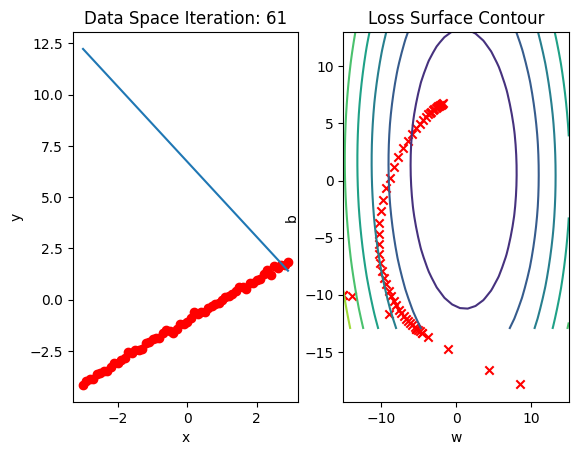

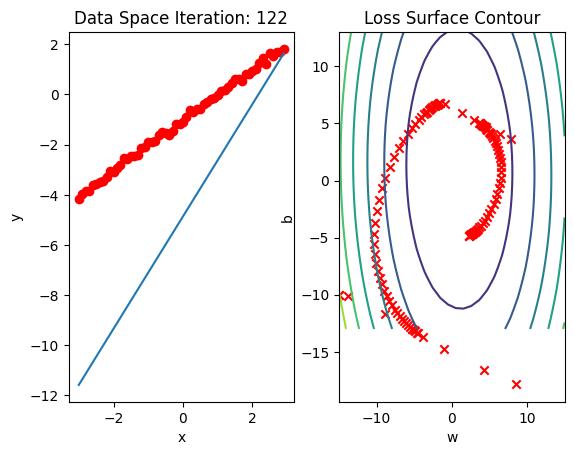

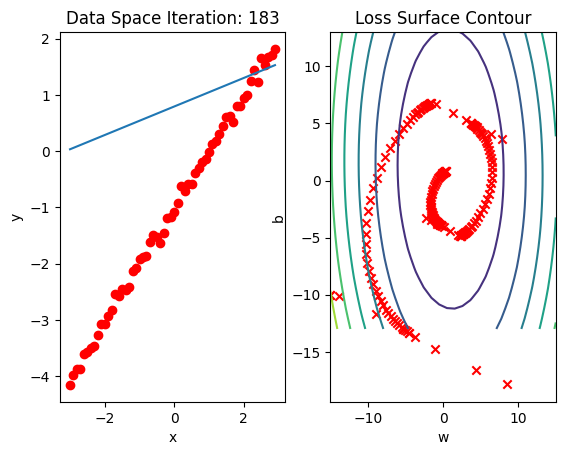

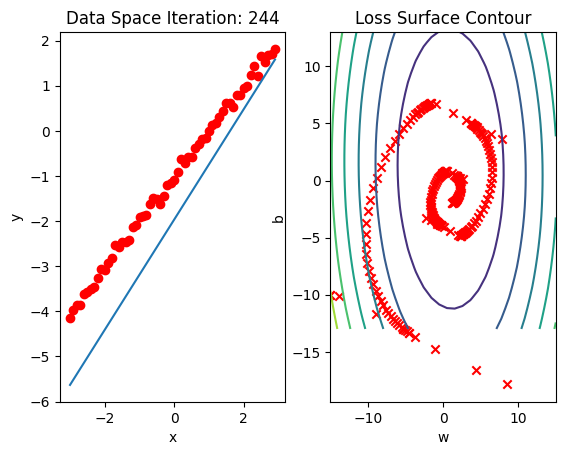

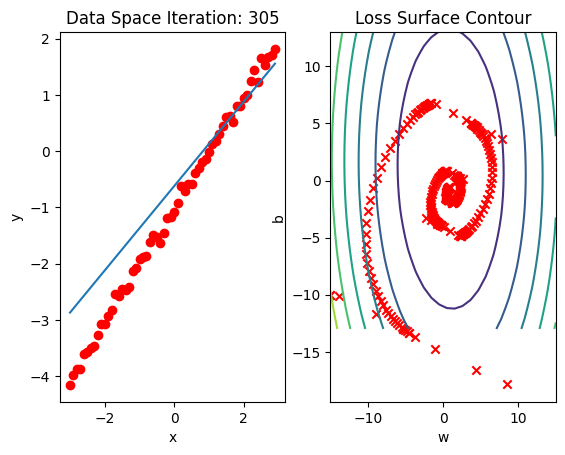

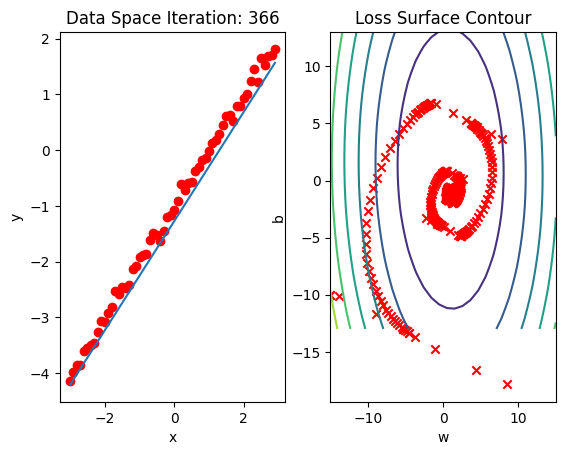

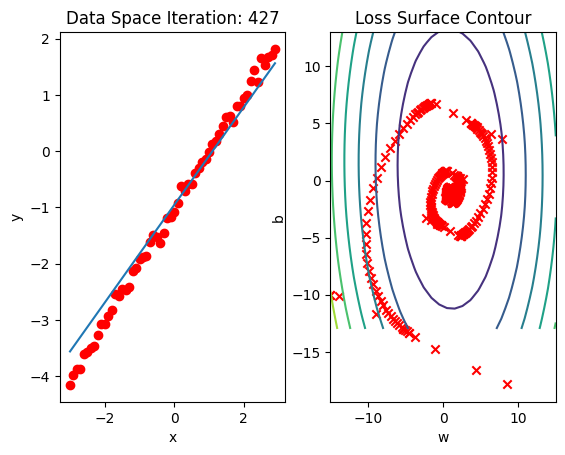

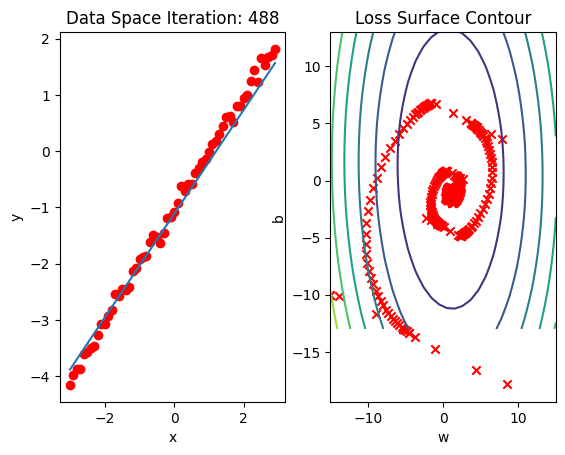

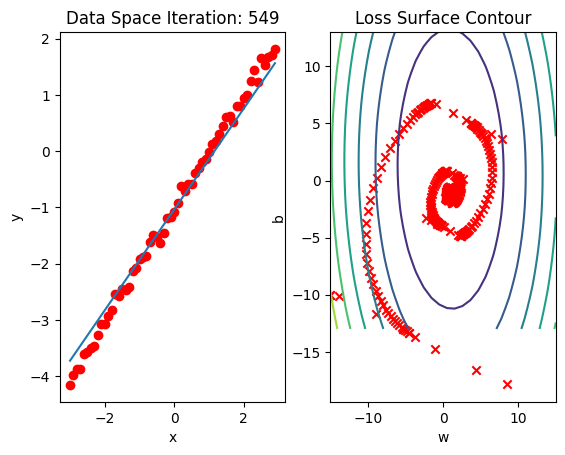

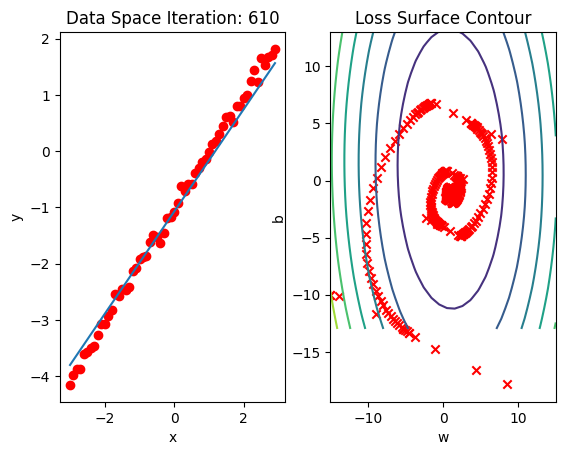

In [17]:
train_model_SGD(10)  # Train the model for 10 epochs using SGD

# Train the Model: Mini-Batch Gradient Descent: Batch Size Equals 5

In [21]:
# Creating a plot_error_surfaces object for visualizing parameter updates (but don't plot immediately)
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)  # Initialize visualization (no plot yet)

# Creating a DataLoader object for mini-batch processing with batch size of 5
dataset = Data(X, Y)  # Create a custom dataset from X and Y
trainloader = DataLoader(dataset=dataset, batch_size=5)  # DataLoader for mini-batch gradient descent

# Defining the model parameters and function to train the model
w = torch.tensor(-15.0, requires_grad=True)  # Initialize weight w with gradient tracking
b = torch.tensor(-10.0, requires_grad=True)  # Initialize bias b with gradient tracking
LOSS_MINI5 = []  # List to store loss values for each iteration
lr = 0.1  # Set the learning rate for gradient descent

def train_model_MINI5(epochs):
    for epoch in range(epochs):  # Loop over the number of epochs
        y_pred = forward(X)  # Predict for all data using current w and b
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Y, y_pred).tolist())  # Record parameters and loss
        LOSS_MINI5.append(criterion(forward(X), Y).tolist())  # Store current loss
        for x, y in trainloader:  # Loop over each mini-batch
            y_pred = forward(x)  # Predict for the mini-batch
            loss = criterion(y, y_pred)  # Compute loss for the mini-batch
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())  # Record parameters and loss
            loss.backward()  # Compute gradients for w and b
            w.data = w.data - lr * w.grad.data  # Update weight using gradient descent
            b.data = b.data - lr * b.grad.data  # Update bias using gradient descent
            w.grad.data.zero_()  # Zero gradients for next iteration
            b.grad.data.zero_()  # Zero gradients for next iteration
        LOSS_MINI5.append(criterion(forward(X), Y).tolist())  # Store loss after epoch
        get_surface.plot_ps()   # Plot parameter updates and loss surface after each epoch


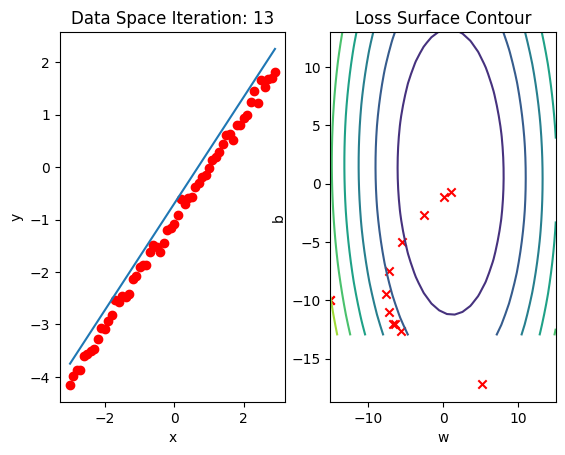

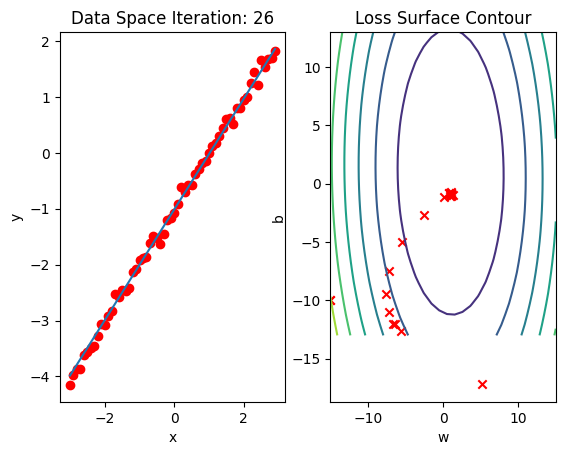

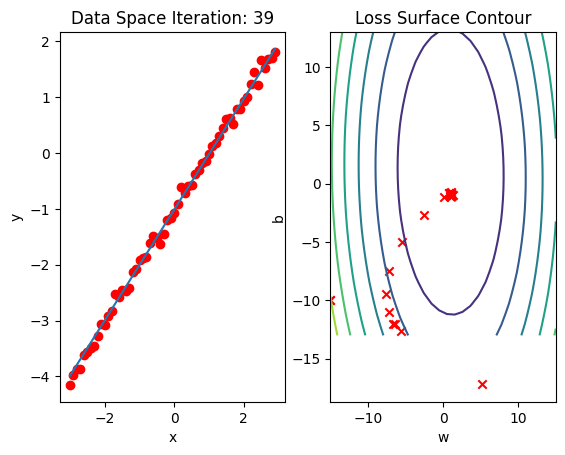

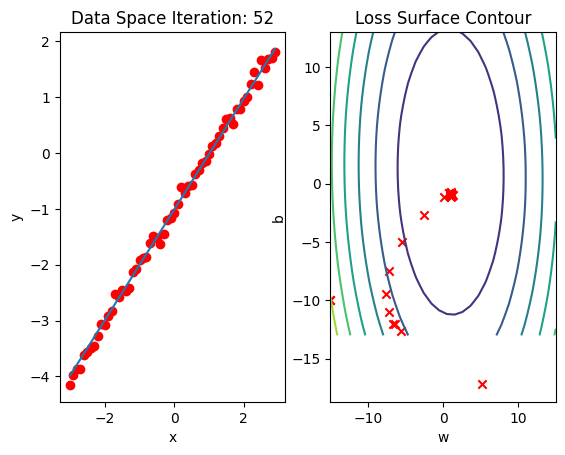

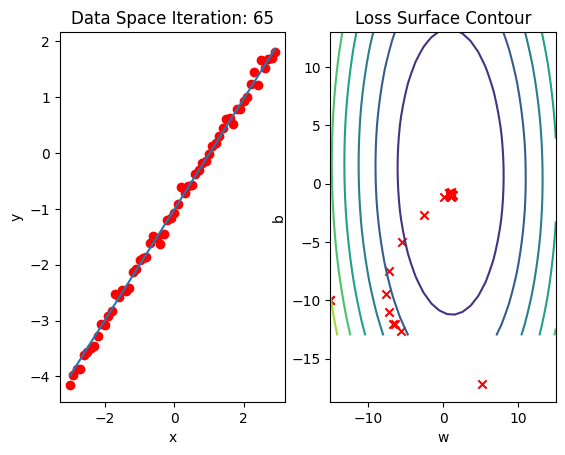

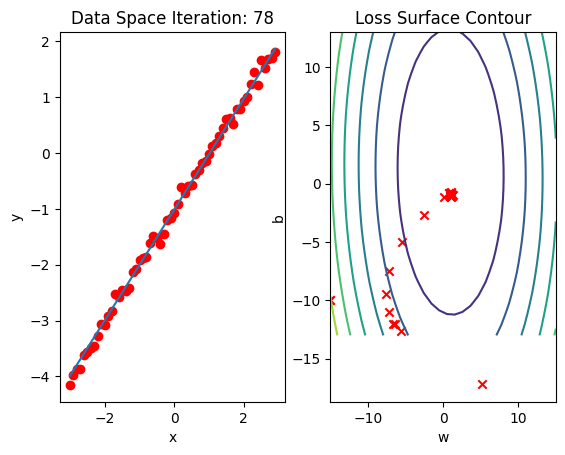

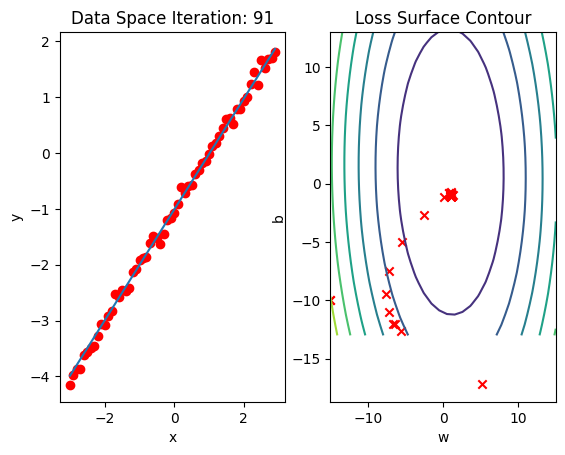

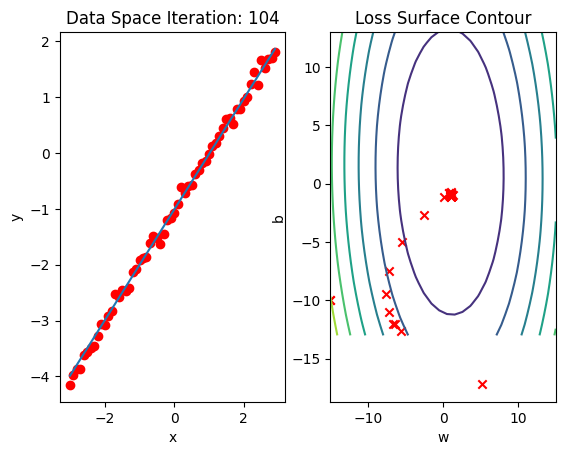

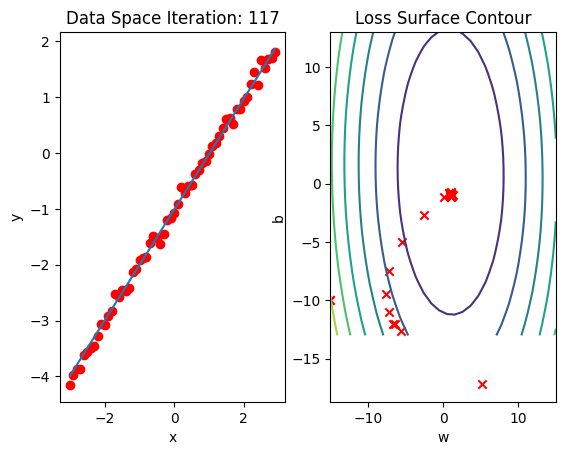

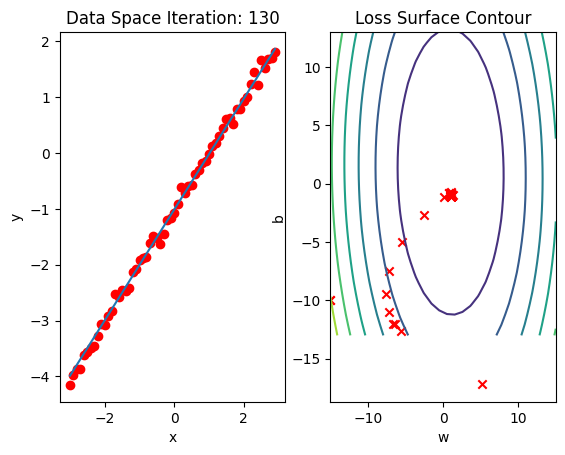

In [22]:
train_model_MINI5(10)

# Train the Model: Mini-Batch Gradient Descent: Batch Size Equals 10

In [25]:
# Creating a plot_error_surfaces object for visualizing parameter updates (but don't plot immediately)
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)  # Initialize visualization (no plot yet)

# Creating a DataLoader object for mini-batch processing with batch size of 10
dataset = Data(X, Y)  # Create a custom dataset from X and Y
trainloader = DataLoader(dataset=dataset, batch_size=10)  # DataLoader for mini-batch gradient descent

# Defining the model parameters and function to train the model
w = torch.tensor(-15.0, requires_grad=True)  # Initialize weight w with gradient tracking
b = torch.tensor(-10.0, requires_grad=True)  # Initialize bias b with gradient tracking
LOSS_MINI10 = []  # List to store loss values for each iteration
lr = 0.1  # Set the learning rate for gradient descent

def train_model_MINI10(epochs):
    for epoch in range(epochs):  # Loop over the number of epochs
        y_pred = forward(X)  # Predict for all data using current w and b
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Y, y_pred).tolist())  # Record parameters and loss
        LOSS_MINI10.append(criterion(forward(X), Y).tolist())  # Store current loss
        for x, y in trainloader:  # Loop over each mini-batch
            y_pred = forward(x)  # Predict for the mini-batch
            loss = criterion(y, y_pred)  # Compute loss for the mini-batch
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())  # Record parameters and loss
            loss.backward()  # Compute gradients for w and b
            w.data = w.data - lr * w.grad.data  # Update weight using gradient descent
            b.data = b.data - lr * b.grad.data  # Update bias using gradient descent
            w.grad.data.zero_()  # Zero gradients for next iteration
            b.grad.data.zero_()  # Zero gradients for next iteration
        LOSS_MINI10.append(criterion(forward(X), Y).tolist())  # Store loss after epoch
        get_surface.plot_ps()   # Plot parameter updates and loss surface after each epoch

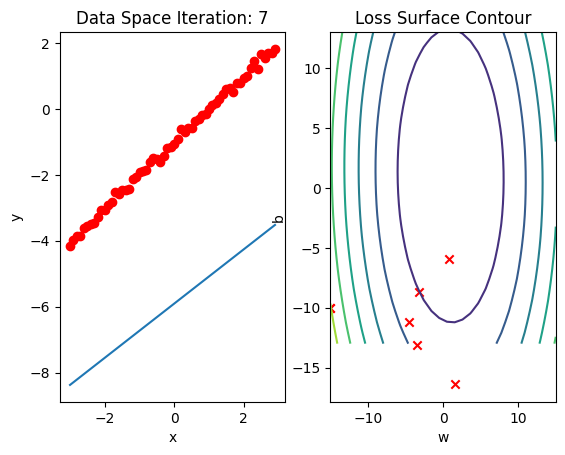

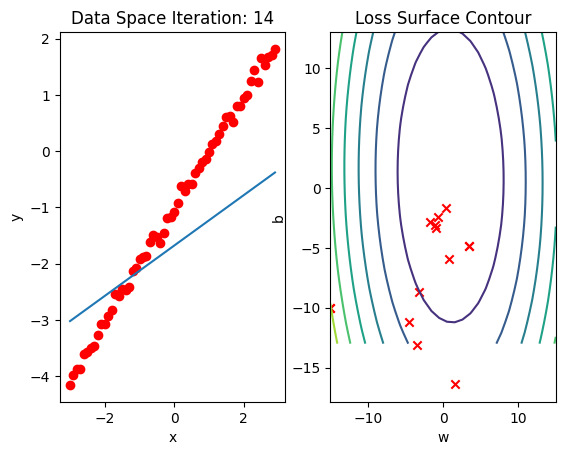

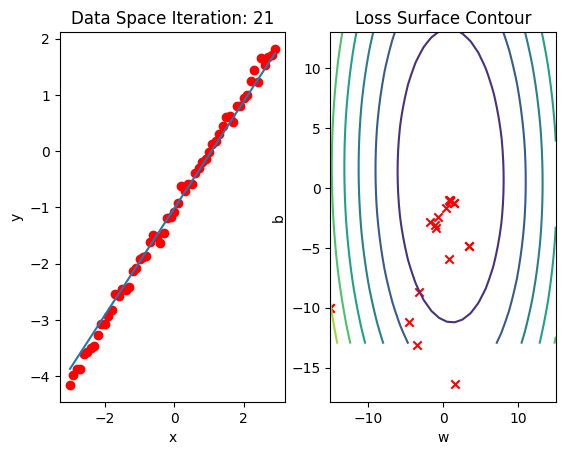

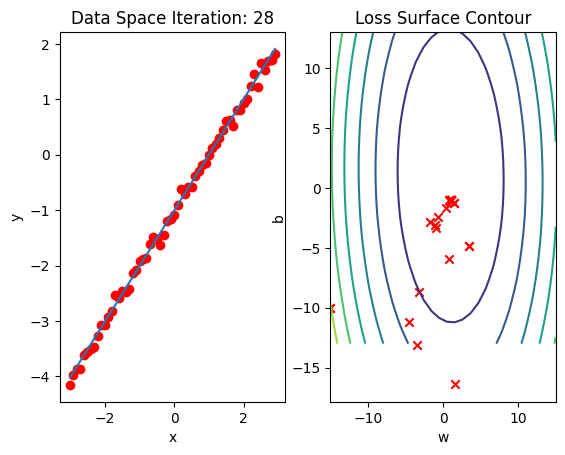

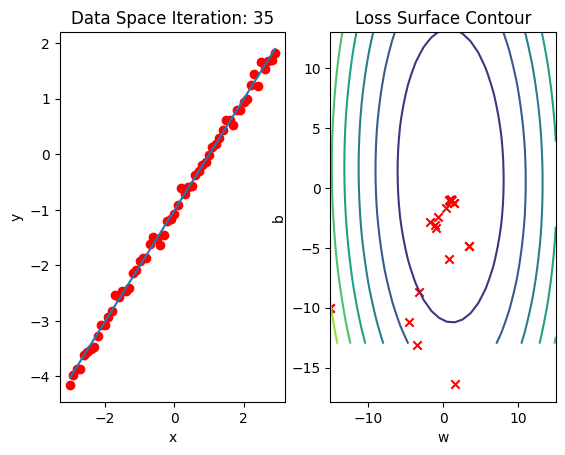

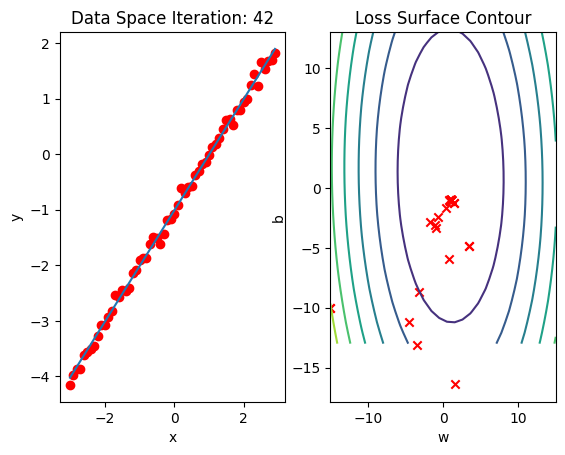

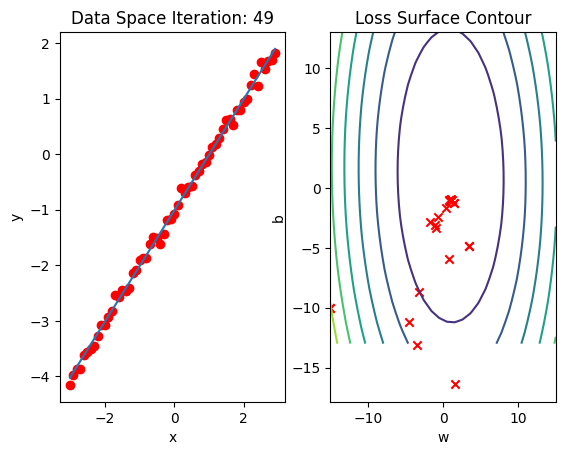

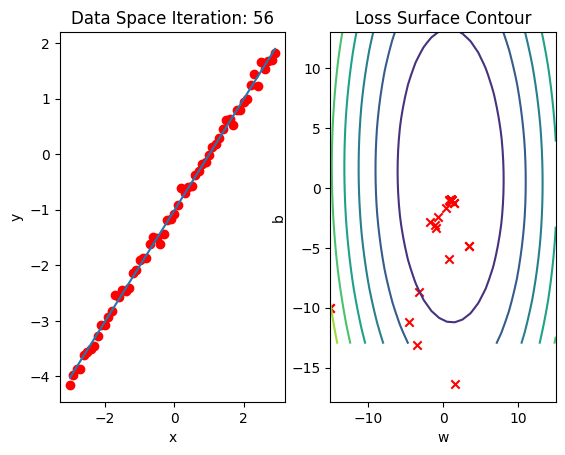

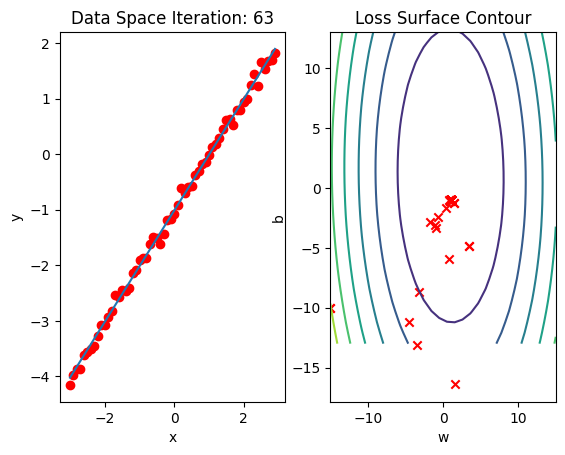

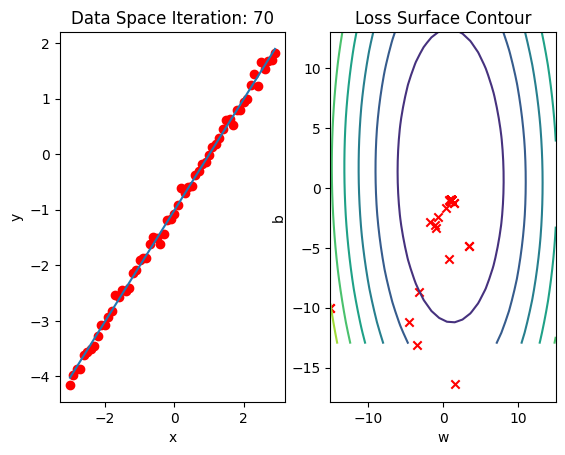

In [26]:
train_model_MINI10(10)

# Train the Model: Mini-Batch Gradient Descent: Batch Size Equals 20

In [29]:
# Creating a plot_error_surfaces object for visualizing parameter updates (but don't plot immediately)
get_surface = plot_error_surfaces(15, 13, X, Y, 30, go = False)  # Initialize visualization (no plot yet)

# Creating a DataLoader object for mini-batch processing with batch size of 20
dataset = Data(X, Y)  # Create a custom dataset from X and Y
trainloader = DataLoader(dataset=dataset, batch_size=20)  # DataLoader for mini-batch gradient descent

# Defining the model parameters and function to train the model
w = torch.tensor(-15.0, requires_grad=True)  # Initialize weight w with gradient tracking
b = torch.tensor(-10.0, requires_grad=True)  # Initialize bias b with gradient tracking
LOSS_MINI20 = []  # List to store loss values for each iteration
lr = 0.1  # Set the learning rate for gradient descent

def train_model_MINI20(epochs):
    for epoch in range(epochs):  # Loop over the number of epochs
        y_pred = forward(X)  # Predict for all data using current w and b
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), criterion(Y, y_pred).tolist())  # Record parameters and loss
        LOSS_MINI20.append(criterion(forward(X), Y).tolist())  # Store current loss
        for x, y in trainloader:  # Loop over each mini-batch
            y_pred = forward(x)  # Predict for the mini-batch
            loss = criterion(y, y_pred)  # Compute loss for the mini-batch
            get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())  # Record parameters and loss
            loss.backward()  # Compute gradients for w and b
            w.data = w.data - lr * w.grad.data  # Update weight using gradient descent
            b.data = b.data - lr * b.grad.data  # Update bias using gradient descent
            w.grad.data.zero_()  # Zero gradients for next iteration
            b.grad.data.zero_()  # Zero gradients for next iteration
        LOSS_MINI20.append(criterion(forward(X), Y).tolist())  # Store loss after epoch
        get_surface.plot_ps()   # Plot parameter updates and loss surface after each epoch

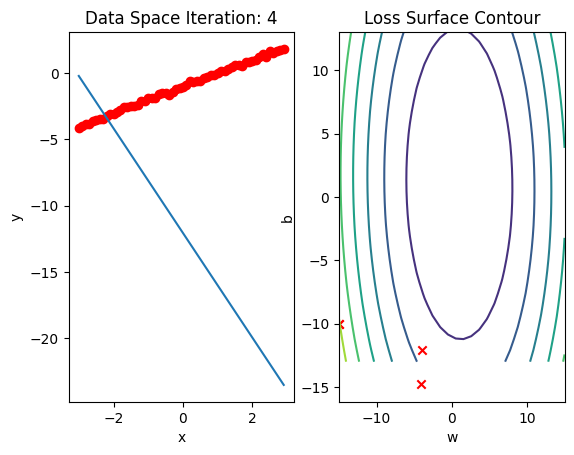

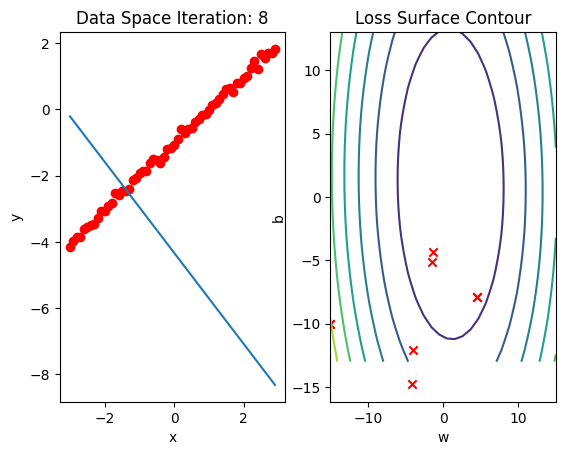

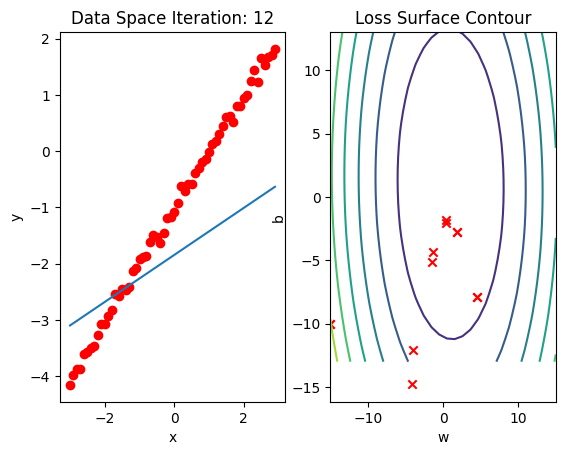

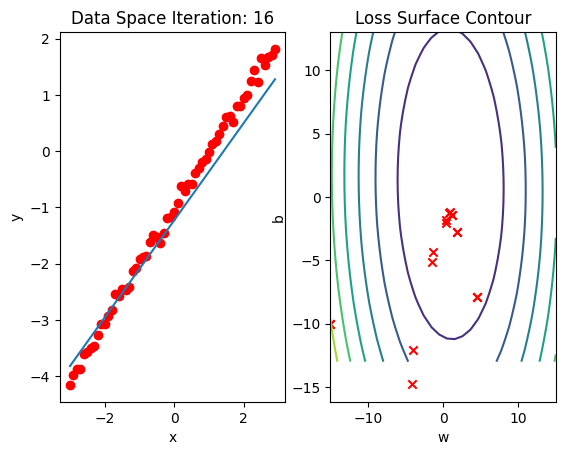

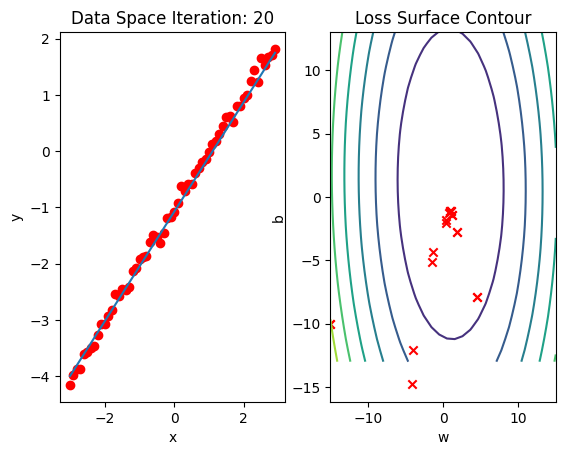

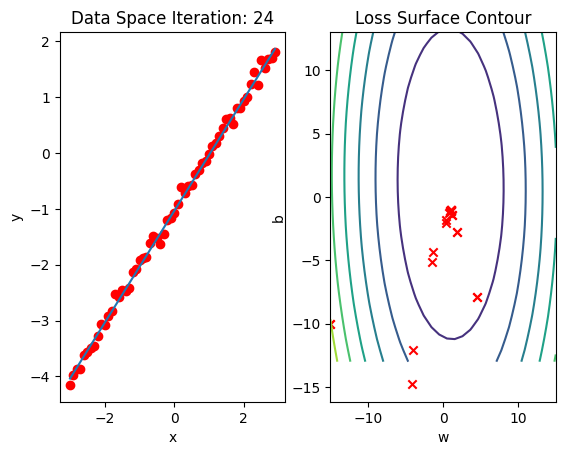

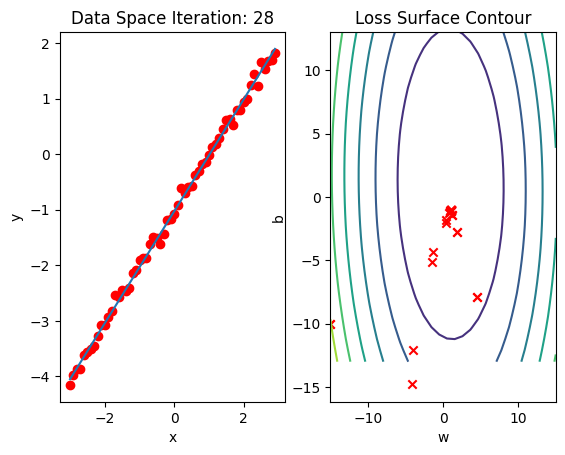

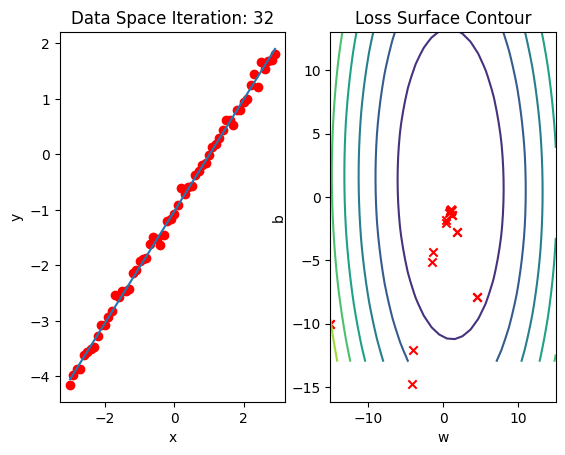

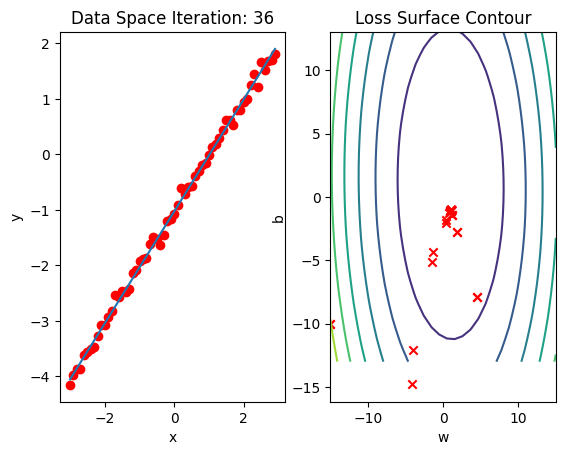

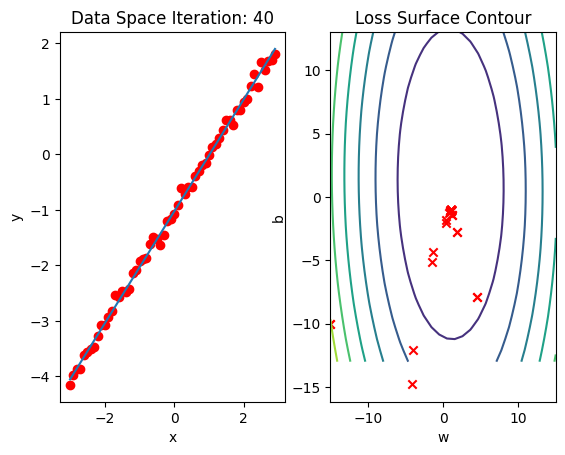

In [30]:
train_model_SGD(10)  # Train the model for 10 epochs using SGD

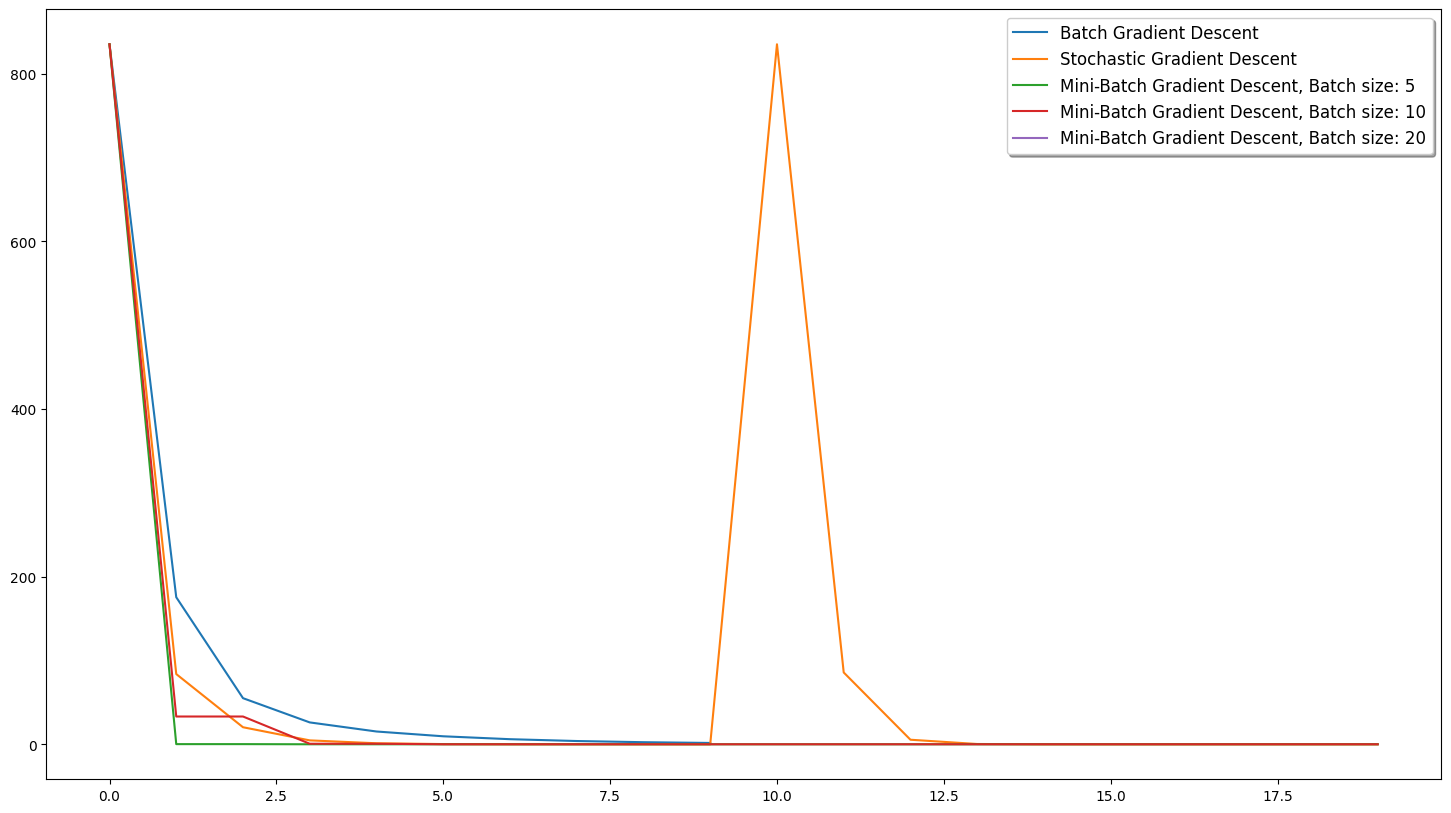

In [33]:
# Plot out the LOSS for each method
LOSS_BGD_converted = []
for loss in LOSS_BGD:
    if hasattr(loss, 'detach'):  # Check if it's a PyTorch tensor
        LOSS_BGD_converted.append(loss.detach().numpy())
    else:  # It's already a numpy array or regular number
        LOSS_BGD_converted.append(loss)

plt.figure(figsize=(18, 10))
plt.plot(LOSS_BGD_converted, label="Batch Gradient Descent")
plt.plot(LOSS_SGD, label="Stochastic Gradient Descent")
plt.plot(LOSS_MINI5, label="Mini-Batch Gradient Descent, Batch size: 5")
plt.plot(LOSS_MINI10, label="Mini-Batch Gradient Descent, Batch size: 10")
plt.plot(LOSS_MINI20, label="Mini-Batch Gradient Descent, Batch size: 20")
plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)